# Test repository in the building process

### 1. Preprocessing

In [1]:
# Load
from load import load_data
from train import train_model
train_df, submission_df = load_data()

In [2]:
from preprocess import preprocess

A_tilde, standardized_train_ratings, train_users, train_items, means, stds, val_users, val_items, standardized_val_ratings, submission_users, submission_items = preprocess((train_df, submission_df))

### 2. Training

In [3]:
# Model and optimizer hyperparameters
L=1
K=30
MODEL_NAME="concat_nonlinear"
INIT_EMBS_STD=0.1
LR=0.08
WEIGHT_DECAY=1e-04

# Train loop hyperparameters
EPOCHS=500
STOP_THRESHOLD=1e-06

In [4]:
from models import ConcatNonLinear
from config import DEVICE
import torch
from torch import nn
model = ConcatNonLinear(A_tilde, K, L, INIT_EMBS_STD).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()

In [5]:
# TODO: check how to save models for hyper-parameter-tuning

In [7]:
from train import train_model
# model, optimizer, loss_fn, train_users, train_items, train_ratings, val_users, val_items, val_ratings, n_epochs, improvement_threshold) -> tuple[list, list]:
train_rmse, val_rmse = train_model(model, optimizer, loss_fn, train_users, train_items, standardized_train_ratings, val_users, val_items, standardized_val_ratings, EPOCHS, STOP_THRESHOLD, save_best_model=True)

Epoch 0 - Train loss: 1.0059 - Val loss: 0.9974


RuntimeError: Parent directory ..data/logs does not exist.

### 3. Check training results

In [ ]:
# Training stats
from matplotlib import pyplot as plt

print("Min training loss:", min(train_rmse))
print("Min validation loss:", min(val_rmse))
print("Min validation loss at epoch:", val_rmse.index(min(val_rmse)))

# Replace values above 10 with 10 in the rmse lists
train_rmse_plot = [min(1, x) for x in train_rmse]
val_rmse = [min(1, x) for x in val_rmse]

# Plot train and val rmse
plt.plot(train_rmse_plot, label='train')
plt.plot(val_rmse, label='val')
# annotate min val loss
plt.annotate(round(min(val_rmse), 4), (val_rmse.index(min(val_rmse)), min(val_rmse)), textcoords="offset points", xytext=(0,-10), ha='center')


plt.legend()
plt.show()

NameError: name 'train_rmse' is not defined

### 4. Post-processing

In [ ]:
# Read model that achieved best validation loss
model.eval()
model.load_state_dict(torch.load("../data/models/best_val_model.pth")["model_state_dict"])

# Get predictions for submission
final_ratings = model.get_ratings(submission_users, submission_items).cpu().detach().numpy()

NameError: name 'model' is not defined

In [ ]:
# Check min and max of final_ratings
print("min:", final_ratings.min())
print("max:", final_ratings.max())
print("mean:", final_ratings.mean())

# Check distribution of final_ratings
plt.hist(final_ratings.flatten(), bins=100)
plt.show()

NameError: name 'final_ratings' is not defined

In [ ]:
import numpy as np
from config import N_u, N_v
# Reverse standardization

# Fill matrix with predictions
final_ratings_matrix = np.zeros((N_u, N_v))
final_ratings_matrix[submission_users, submission_items] = final_ratings

# Reverse standardization (no mask needed)
def reverse_standardization(submission_matrix, means, stds):
    # shape of all inputs: (n_users, n_items)
    reversed_ratings = submission_matrix * stds + means
    return reversed_ratings

final_ratings_matrix = reverse_standardization(final_ratings_matrix, means, stds)

# extract numpy array from ratings matrix
final_ratings = final_ratings_matrix[submission_users, submission_items]

NameError: name 'final_ratings' is not defined

In [ ]:
# Clip at 1 and 5

# check min and max of final_ratings_rounded
print("min:", final_ratings.min().item())
print("max:", final_ratings.max().item())
print("mean:", final_ratings.mean().item())

# Count the number of values under 1 and over 5
count_under_1 = (final_ratings < 1).sum().item()
count_over_5 = (final_ratings > 5).sum().item()
print("count_over_5:", count_over_5)
print("count_under_1:", count_under_1)

# Clip the values to be within the range [1, 5]
final_ratings = final_ratings.clip(final_ratings, 1, 5)

min: -0.10219716280698776
max: 6.083968162536621
mean: 3.858973979949951
count_over_5: 21692
count_under_1: 203


min: 1.0
max: 5.0
mean: 3.8562610149383545


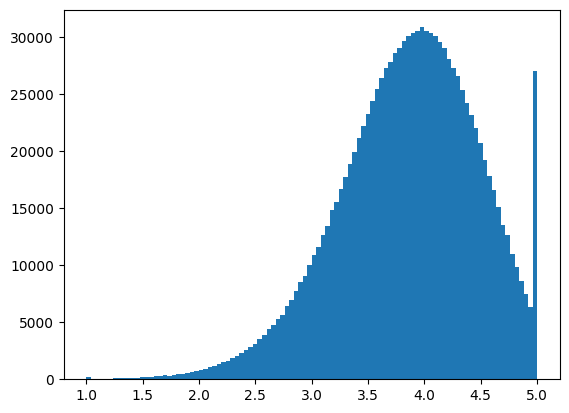

In [ ]:
# check min and max of final_ratings
print("min:", final_ratings.min().item())
print("max:", final_ratings.max().item())
print("mean:", final_ratings.mean().item())

# check distribution of final_ratings
plt.hist(final_ratings.flatten(), bins=100)
plt.show()

### 5. Submission

In [ ]:
# save submission
import pandas as pd

def to_submission_format(users, movies, predictions):
    return pd.DataFrame(data={'Id': ['r{}_c{}'.format(user + 1, movie + 1) for user, movie in zip(users, movies)],
                              'Prediction': predictions})

submission = to_submission_format(submission_users, submission_movies, final_ratings)

submission.to_csv('../data/submission_data/submission.csv', index=False)